# 1주차 - 고객 대출등급 분류 해커톤

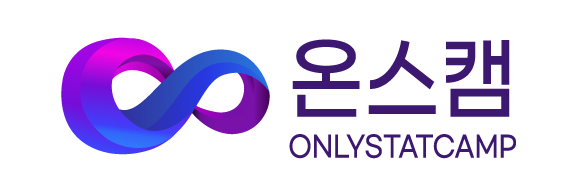

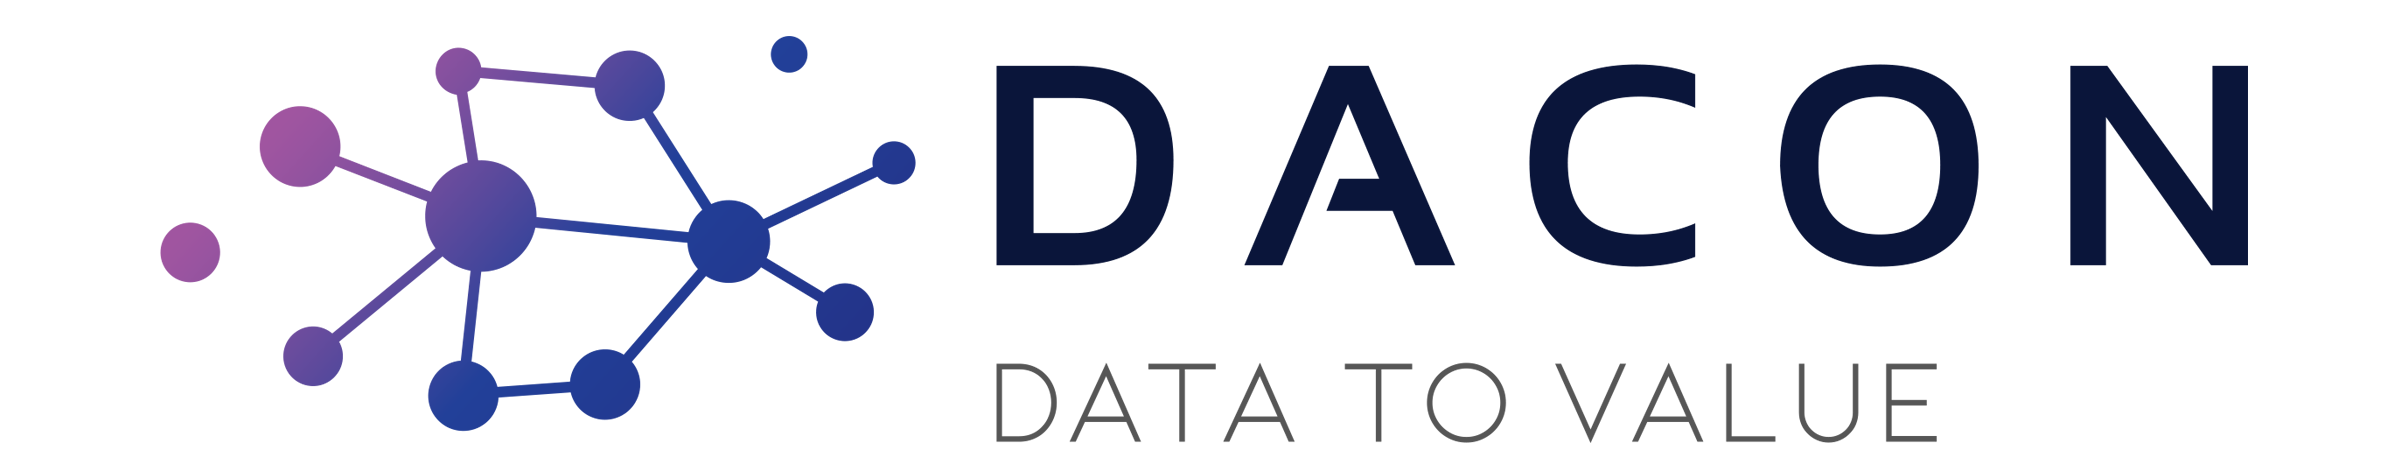

---

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tqdm.auto import tqdm

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

---

## 데이터 설명

- Dataset Info.

- train.csv [파일] 
    - 고객 관련 금융 정보
    - ID : 대출 고객의 고유 ID
    - 대출등급 : 예측 목표


- test.csv [파일]
    - 고객 관련 금융 정보
    - ID : 대출 고객의 고유 ID
    - 대출등급이 존재하지 않음


- sample_submission.csv [파일] - 제출 양식
    - ID : 대출 고객의 고유 ID
    - 대출등급 : test.csv에서 제공된 고객의 대출등급을 예측하여 기입

---

## 데이터 불러오기

### train

In [6]:
train_df = pd.read_csv("train.csv")

In [7]:
train_df.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [9]:
train_df.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [10]:
train_df.대출등급.value_counts()

B    28817
C    27623
A    16772
D    13354
E     7354
F     1954
G      420
Name: 대출등급, dtype: int64

In [11]:
Grade2Label = {
    "A" : 0,
    "B" : 1,
    "C" : 2,
    "D" : 3,
    "E" : 4,
    "F" : 5,
    "G" : 6,
}

In [12]:
Label2Grade = {v : k for k, v in Grade2Label.items()}

In [13]:
train_df["대출등급"] = train_df.대출등급.apply(lambda x: Grade2Label[x])

### test

In [15]:
test_df = pd.read_csv("test.csv")

In [16]:
test_df.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0
3,TEST_00003,14400000,36 months,5 years,MORTGAGE,66000000,13.72,30,신용 카드,1,669024,281724.0,0.0,0.0
4,TEST_00004,27600000,36 months,5 years,RENT,55200000,30.50,12,신용 카드,0,1250052,614844.0,0.0,0.0


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            64197 non-null  object 
 1   대출금액          64197 non-null  int64  
 2   대출기간          64197 non-null  object 
 3   근로기간          64197 non-null  object 
 4   주택소유상태        64197 non-null  object 
 5   연간소득          64197 non-null  int64  
 6   부채_대비_소득_비율   64197 non-null  float64
 7   총계좌수          64197 non-null  int64  
 8   대출목적          64197 non-null  object 
 9   최근_2년간_연체_횟수  64197 non-null  int64  
 10  총상환원금         64197 non-null  int64  
 11  총상환이자         64197 non-null  float64
 12  총연체금액         64197 non-null  float64
 13  연체계좌수         64197 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 6.9+ MB


---

In [17]:
sample_submission = pd.read_csv("sample_submission.csv")

In [18]:
sample_submission

,ID,대출등급
0,TEST_00000,G
1,TEST_00001,G
2,TEST_00002,G
3,TEST_00003,G
4,TEST_00004,G
...,...,...
64192,TEST_64192,G
64193,TEST_64193,G
64194,TEST_64194,G
64195,TEST_64195,G


---

## 데이터 전처리

데이터 전처리 단계에서는 수치형 데이터의 정규화, 범주형 데이터의 원-핫 인코딩, 결측치 처리 등을 수행합니다. 대출등급이 타겟 변수이므로, 이를 제외한 다른 특성들을 입력 변수로 사용할 것입니다.

In [19]:
# 범주형 데이터와 수치형 데이터 분리
categorical_cols = train_df.select_dtypes(include=['object']).columns
numeric_cols = train_df.select_dtypes(exclude=['object']).columns

In [20]:
categorical_cols 

Index(['ID', '대출기간', '근로기간', '주택소유상태', '대출목적'], dtype='object')

In [21]:
numeric_cols

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자',
       '총연체금액', '연체계좌수', '대출등급'],
      dtype='object')

In [22]:
categorical_cols = [
    '대출기간', '근로기간', '주택소유상태', '대출목적'
]

In [23]:
numeric_cols = [
    '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
]

In [24]:
train_df[numeric_cols]

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,72000000,18.90,15,0,0,0.0,0.0,0.0
1,14400000,130800000,22.33,21,0,373572,234060.0,0.0,0.0
2,12000000,96000000,8.60,14,0,928644,151944.0,0.0,0.0
3,14400000,132000000,15.09,15,0,325824,153108.0,0.0,0.0
4,18000000,71736000,25.39,19,0,228540,148956.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
96289,14400000,210000000,9.33,33,0,974580,492168.0,0.0,0.0
96290,28800000,132000000,5.16,25,0,583728,855084.0,0.0,0.0
96291,14400000,84000000,11.24,22,0,1489128,241236.0,0.0,0.0
96292,15600000,66330000,17.30,21,2,1378368,818076.0,0.0,0.0


### 수치형 데이터 정규화

In [25]:
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(train_df[numeric_cols])

In [26]:
scaled_numeric.shape

(96294, 9)

In [27]:
train_df[categorical_cols]

,대출기간,근로기간,주택소유상태,대출목적
0,36 months,6 years,RENT,부채 통합
1,60 months,10+ years,MORTGAGE,주택 개선
2,36 months,5 years,MORTGAGE,부채 통합
3,36 months,8 years,MORTGAGE,부채 통합
4,60 months,Unknown,RENT,주요 구매
...,...,...,...,...
96289,36 months,10+ years,MORTGAGE,신용 카드
96290,60 months,10+ years,MORTGAGE,주택 개선
96291,36 months,1 year,MORTGAGE,신용 카드
96292,36 months,5 years,MORTGAGE,부채 통합


### 범주형 데이터 원-핫 인코딩

In [28]:
encoder = OneHotEncoder()
encoded_categorical = encoder.fit_transform(train_df[categorical_cols])

In [29]:
encoded_categorical.shape

(96294, 34)

In [30]:
encoded_categorical_df = pd.DataFrame(encoded_categorical)

In [31]:
encoded_categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       96294 non-null  object
dtypes: object(1)
memory usage: 752.4+ KB


### 만약 범주형 classes가 많다면, 메모리 이슈!

---

## tf.data를 사용하여 입력 파이프라인 만들기

In [32]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('대출등급')
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    print(df)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [33]:
batch_size = 5
train_ds = df_to_dataset(train_df, batch_size=batch_size)

/tmp/ipykernel_951771/3523935162.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [34]:
[(train_features, label_batch)] = train_ds.take(1)

In [35]:
# 컬렁 종류
list(train_features.keys())

['ID',
 '대출금액',
 '대출기간',
 '근로기간',
 '주택소유상태',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '대출목적',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수',
 '대출등급']

### 

In [36]:
# 대출기간 배치 확인
train_features['대출기간']

<tf.Tensor: shape=(5, 1), dtype=string, numpy=
array([[b' 36 months'],
       [b' 36 months'],
       [b' 36 months'],
       [b' 36 months'],
       [b' 60 months']], dtype=object)>

In [37]:
# 연간소득 배치 확인
train_features['연간소득']

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 52891200],
       [ 54000000],
       [ 75600000],
       [103200000],
       [120000000]])>

In [38]:
# 대출등급 배치 확인
label_batch

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 2, 3])>

## Keras 전처리 레이어 적용하기

Keras 전처리 레이어를 사용하여 Keras 네이티브 입력 처리 파이프라인을 빌드할 수 있습니다. 이러한 입력 처리 파이프라인은 Keras가 아닌 워크플로에서 독립적인 전처리 코드로 사용할 수 있고, Keras 모델과 직접 결합하고, Keras SavedModel의 일부로 내보낼 수 있습니다.

이 튜토리얼에서는 다음 네 가지 전처리 레이어를 사용하여 전처리, 구조적 데이터 인코딩 및 특성 엔지니어링을 수행하는 방법을 보여 줍니다.

* tf.keras.layers.Normalization: 입력 기능의 기능별 정규화를 수행합니다.
* tf.keras.layers.CategoryEncoding: 정수 범주형 기능을 원-핫(one-hot), 멀티-핫(multi-hot) 또는 tf-idf 밀집 표현(dense representations)으로 바꿉니다.
* tf.keras.layers.StringLookup: 문자열 범주형 값을 정수 인덱스로 바꿉니다.
* tf.keras.layers.IntegerLookup: 정수 범주형 값을 정수 인덱스로 바꿉니다.

### 숫자 열

In [39]:
train_df[numeric_cols].head()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,72000000,18.90,15,0,0,0.0,0.0,0.0
1,14400000,130800000,22.33,21,0,373572,234060.0,0.0,0.0
2,12000000,96000000,8.60,14,0,928644,151944.0,0.0,0.0
3,14400000,132000000,15.09,15,0,325824,153108.0,0.0,0.0
4,18000000,71736000,25.39,19,0,228540,148956.0,0.0,0.0


In [40]:
def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer

In [41]:
photo_count_col = train_df['대출금액']
layer = get_normalization_layer('대출금액', train_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [42]:
layer(photo_count_col)

<tf.Tensor: shape=(1, 96294), dtype=float32, numpy=
array([[-0.56386185, -0.37797654, -0.6103332 , ..., -0.37797654,
        -0.2617982 , -0.9356325 ]], dtype=float32)>

## 범주 열

In [43]:
train_df[categorical_cols].head()

,대출기간,근로기간,주택소유상태,대출목적
0,36 months,6 years,RENT,부채 통합
1,60 months,10+ years,MORTGAGE,주택 개선
2,36 months,5 years,MORTGAGE,부채 통합
3,36 months,8 years,MORTGAGE,부채 통합
4,60 months,Unknown,RENT,주요 구매


In [44]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    return lambda feature: encoder(index(feature))

In [45]:
test_type_col = train_features['대출기간']

In [46]:
test_type_col

<tf.Tensor: shape=(5, 1), dtype=string, numpy=
array([[b' 36 months'],
       [b' 36 months'],
       [b' 36 months'],
       [b' 36 months'],
       [b' 60 months']], dtype=object)>

In [47]:
test_type_layer = get_category_encoding_layer(name='대출기간',
                                              dataset=train_ds,
                                              dtype='string')

In [48]:
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

### 모델을 훈련하기 위해 선택한 특성 전처리하기

In [49]:
train, val = train_test_split(train_df, 
                              test_size=0.1, 
                              random_state=42,
                              stratify=train_df.대출등급)

In [50]:
train

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
42259,TRAIN_42259,14400000,60 months,10+ years,MORTGAGE,162000000,35.94,34,주택 개선,2,710664,559428.0,0.0,0.0,2
23748,TRAIN_23748,28800000,60 months,5 years,RENT,177600000,23.69,42,부채 통합,0,380148,205404.0,0.0,0.0,1
48208,TRAIN_48208,9600000,36 months,10+ years,MORTGAGE,66000000,12.18,12,부채 통합,0,218856,98412.0,0.0,0.0,2
37062,TRAIN_37062,3000000,36 months,10+ years,RENT,24270000,5.28,4,부채 통합,0,72708,17580.0,0.0,0.0,1
31730,TRAIN_31730,7200000,36 months,10+ years,MORTGAGE,43200000,39.37,13,주택 개선,2,324432,158580.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27667,TRAIN_27667,9600000,36 months,1 year,MORTGAGE,82200000,20.73,27,신용 카드,1,716376,180456.0,0.0,0.0,0
48942,TRAIN_48942,30000000,60 months,10+ years,MORTGAGE,102000000,6.25,27,부채 통합,1,320664,396432.0,0.0,0.0,3
82142,TRAIN_82142,12000000,36 months,1 year,RENT,72000000,9.62,11,신용 카드,0,522900,305352.0,0.0,0.0,3
81788,TRAIN_81788,28800000,60 months,< 1 year,RENT,90000000,22.35,22,부채 통합,0,302940,365460.0,0.0,0.0,3


In [51]:
val

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
26457,TRAIN_26457,14400000,36 months,6 years,RENT,104400000,15.02,27,부채 통합,0,328284,200340.0,0.0,0.0,2
42175,TRAIN_42175,30000000,60 months,Unknown,OWN,105246000,17.62,33,부채 통합,0,1056660,978732.0,0.0,0.0,2
82677,TRAIN_82677,13440000,60 months,10+ years,MORTGAGE,137390400,22.95,39,주택 개선,1,266424,438108.0,0.0,1.0,4
93439,TRAIN_93439,14400000,36 months,10+ years,MORTGAGE,102000000,14.09,19,부채 통합,1,692268,228900.0,0.0,0.0,1
92270,TRAIN_92270,18720000,36 months,8 years,MORTGAGE,67200000,14.79,29,신용 카드,0,1430016,249420.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15782,TRAIN_15782,19200000,36 months,10+ years,MORTGAGE,78000000,12.24,36,신용 카드,0,1390308,457356.0,0.0,0.0,1
45815,TRAIN_45815,13440000,36 months,5 years,RENT,72000000,19.44,19,부채 통합,0,973212,364896.0,0.0,0.0,1
23313,TRAIN_23313,6000000,36 months,4 years,RENT,31200000,2.31,11,기타,0,1754544,268476.0,0.0,0.0,2
10428,TRAIN_10428,24000000,60 months,10+ years,MORTGAGE,60000000,21.32,33,신용 카드,0,504564,615420.0,0.0,0.0,3


In [52]:
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_951771/3523935162.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_951771/3523935162.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [53]:
train_ds

<PrefetchDataset element_spec=({'ID': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '대출금액': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '대출기간': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '근로기간': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '주택소유상태': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '연간소득': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '부채_대비_소득_비율': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), '총계좌수': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '대출목적': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '최근_2년간_연체_횟수': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '총상환원금': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '총상환이자': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), '총연체금액': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), '연체계좌수': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), '대출등급': TensorSpec(shape=(None, 1), dtyp

In [54]:
val_ds

<PrefetchDataset element_spec=({'ID': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '대출금액': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '대출기간': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '근로기간': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '주택소유상태': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '연간소득': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '부채_대비_소득_비율': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), '총계좌수': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '대출목적': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), '최근_2년간_연체_횟수': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '총상환원금': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), '총상환이자': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), '총연체금액': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), '연체계좌수': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), '대출등급': TensorSpec(shape=(None, 1), dtyp

숫자 특성(애완 동물 사진 수 및 입양비)을 정규화하고 정규화한 숫자 특성을 encoded_features라고 부르는 하나의 입력 목록에 추가합니다.

In [55]:
all_inputs = []
encoded_features = []

for header in tqdm(numeric_cols):
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

  0%|          | 0/9 [00:00<?, ?it/s]

문자열 범주형 값에 대해 동일한 단계를 반복합니다.



In [56]:
for header in tqdm(categorical_cols):
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=None)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

  0%|          | 0/4 [00:00<?, ?it/s]

## 모델 구축

모델은 여러 개의 Dense 층을 가진 신경망을 사용하여 구축할 수 있습니다. 각 층은 다양한 뉴런의 수와 활성화 함수를 가질 수 있습니다.

In [57]:
num_class = len(Grade2Label)

In [58]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(2048, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(num_class, activation='softmax')(x)

model = tf.keras.Model(all_inputs, output)

## 모델 컴파일

모델을 컴파일할 때는 손실 함수, 최적화 알고리즘, 평가 지표를 정의해야 합니다. 분류 문제에서는 일반적으로 sparse_categorical_crossentropy 또는 categorical_crossentropy를 손실 함수로 사용합니다.

https://www.tensorflow.org/guide/keras/custom_callback?hl=ko#%EB%82%B4%EC%9E%A5_keras_%EC%BD%9C%EB%B0%B1

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

https://graphviz.gitlab.io/download/

In [60]:
# !pip install -U pydot

# !pip install -U pydotplus

# !pip install -U graphviz

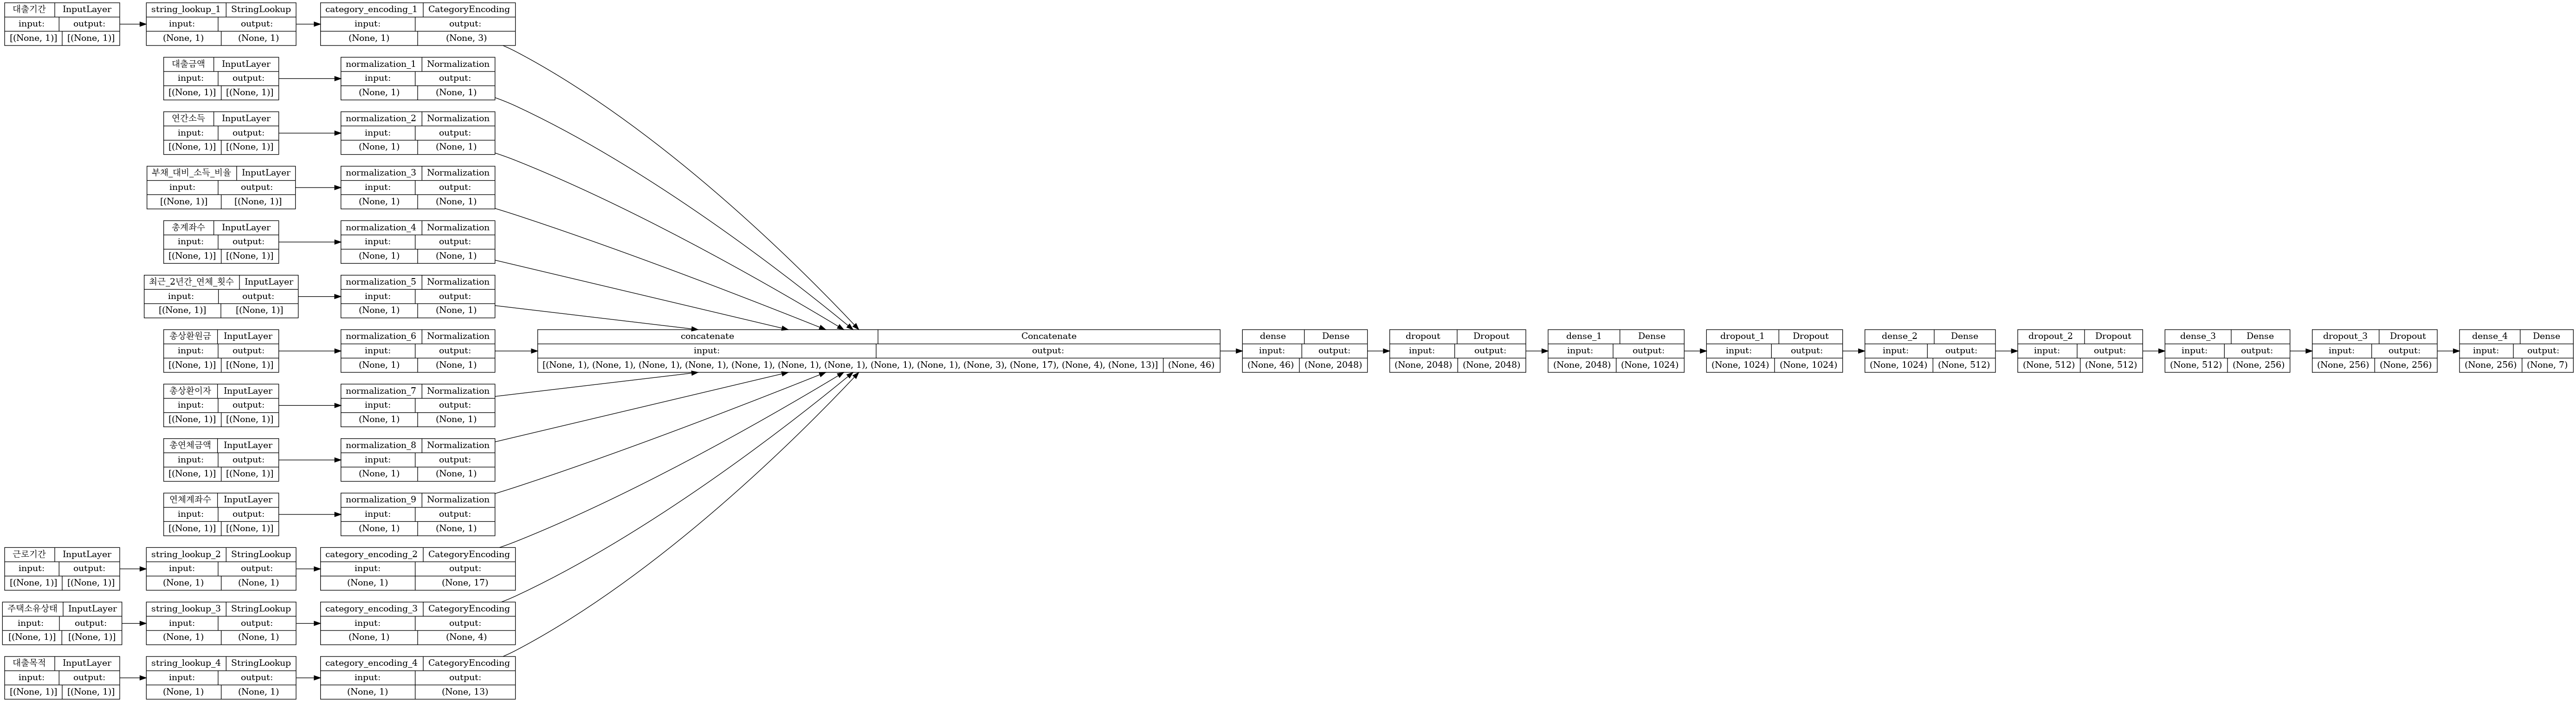

In [61]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

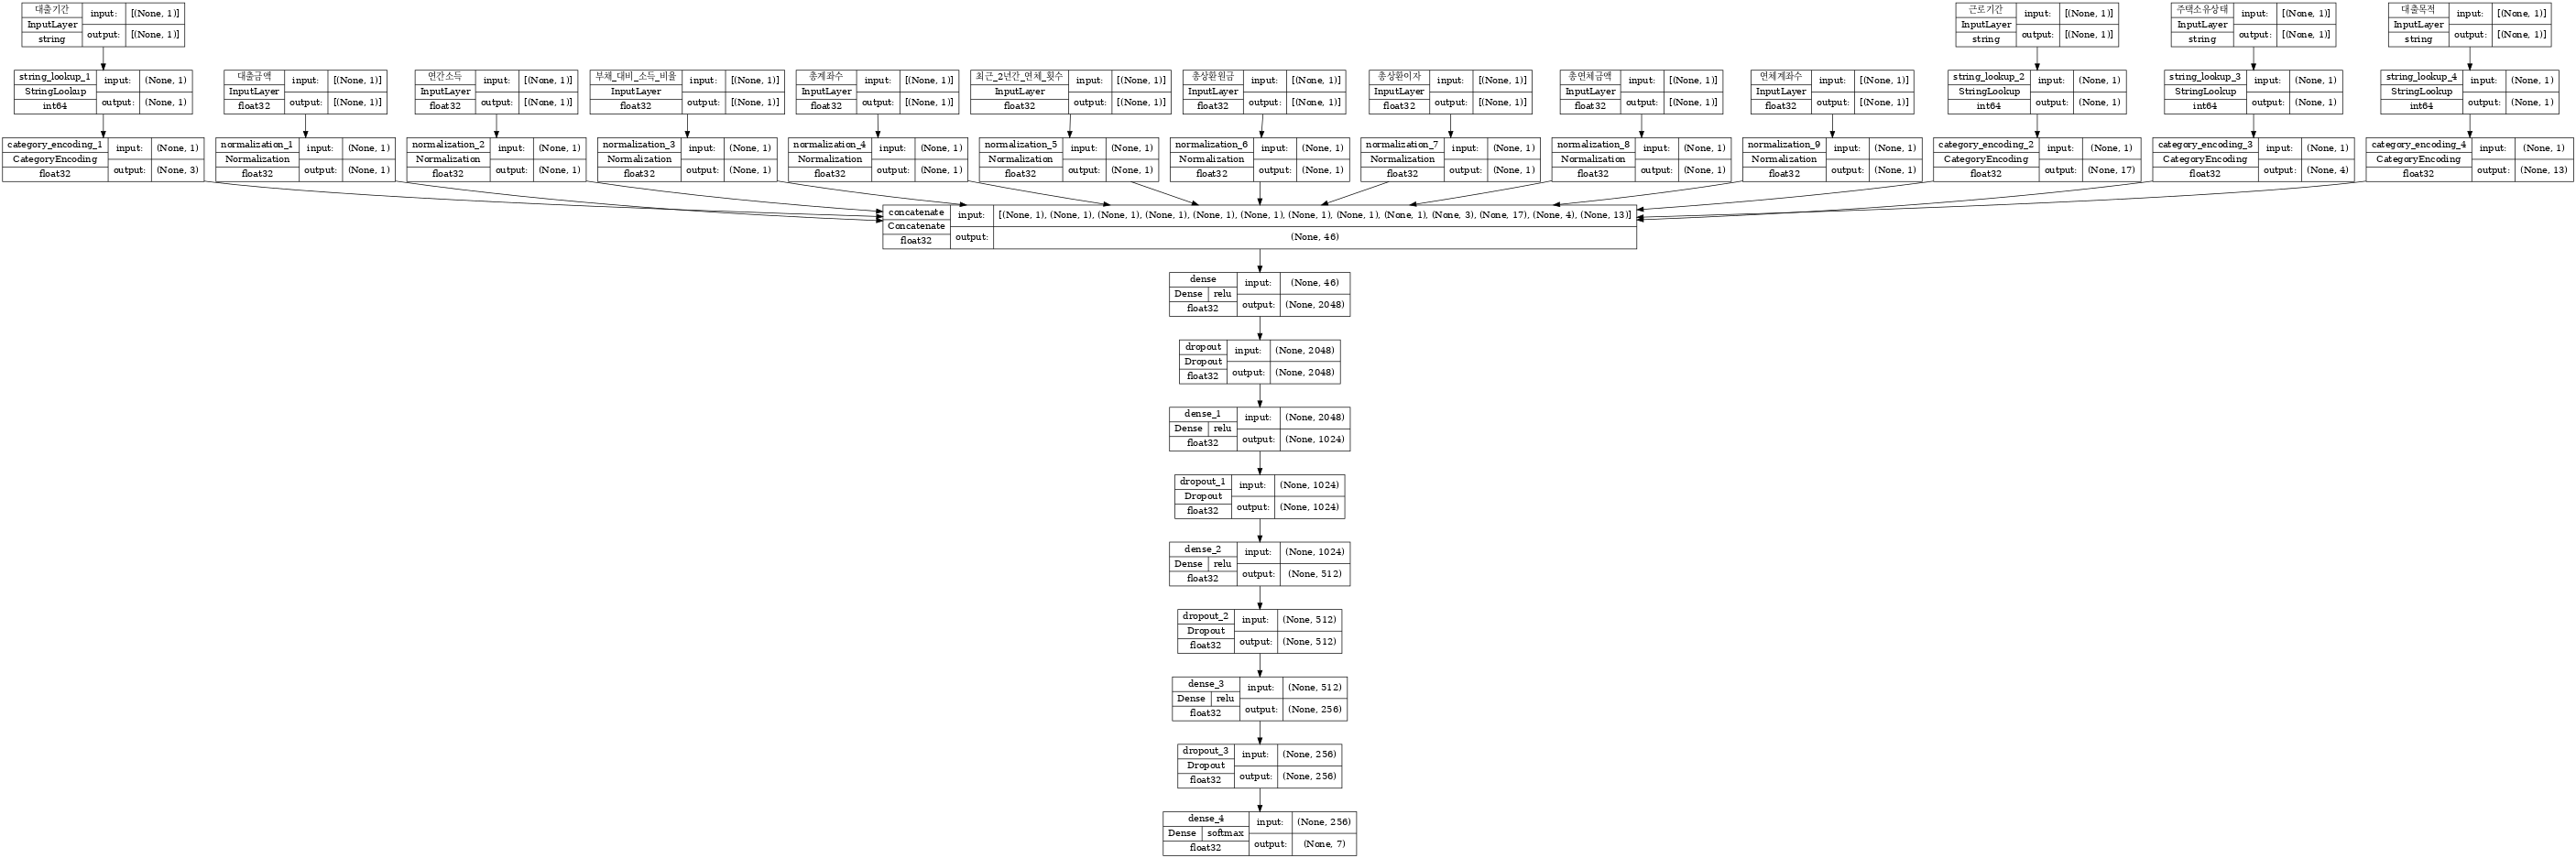

In [62]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True, rankdir="TB", dpi=50)

## 모델 학습

모델을 학습시키기 위해서는 훈련 데이터셋을 모델에 제공하고, 에포크 수를 정의해야 합니다. 또한, 검증 데이터셋을 사용하여 학습 과정에서 모델의 성능을 평가할 수 있습니다.

In [63]:
history = model.fit(train_ds, 
          epochs=100, 
          validation_data=val_ds,
          callbacks=[
              EarlyStopping(monitor="val_loss", patience=10),
              ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
          ])

Epoch 1/100


/home/juing/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['ID', '대출등급'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1355/1355 [==============================] - 11s 6ms/step - loss: 0.9712 - accuracy: 0.5943 - val_loss: 0.6701 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 2/100
1355/1355 [==============================] - 9s 6ms/step - loss: 0.7407 - accuracy: 0.6962 - val_loss: 0.6161 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 3/100
1355/1355 [==============================] - 9s 6ms/step - loss: 0.6974 - accuracy: 0.7168 - val_loss: 0.5807 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 4/100
1355/1355 [==============================] - 9s 6ms/step - loss: 0.6782 - accuracy: 0.7267 - val_loss: 0.5776 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 5/100
1355/1355 [==============================] - 9s 6ms/step - loss: 0.6653 - accuracy: 0.7325 - val_loss: 0.6058 - val_accuracy: 0.7896 - lr: 0.0010
Epoch 6/100
1355/1355 [==============================] - 9s 6ms/step - loss: 0.6539 - accuracy: 0.7369 - val_loss: 0.5928 - val_accuracy: 0.7610 - lr: 0.0010
Epoch 7/100
1355/1355 [==============================] - 9s 6ms

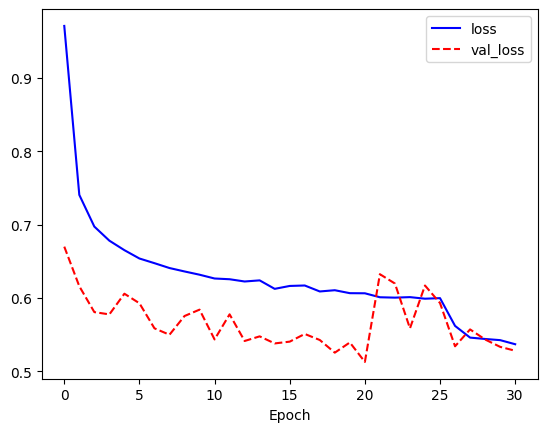

In [64]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 모델 평가

학습이 완료된 후, 테스트 데이터셋을 사용하여 모델의 최종 성능을 평가합니다.



In [65]:
loss, accuracy = model.evaluate(val_ds)

151/151 [==============================] - 1s 4ms/step - loss: 0.5280 - accuracy: 0.8090


In [66]:
print("Accuracy", accuracy)

Accuracy 0.8090342879295349


### tensroflow 변수들은 영어로 작성해야 모델이 저장된다.

In [67]:
# model.save('my_pet_classifier')

In [68]:
# reloaded_model = tf.keras.models.load_model('my_pet_classifier')

### Macro F1 Score의 설명과 샘플코드




Macro F1 Score는 다중 클래스 분류 문제에서 모델의 성능을 평가하는 데 사용되는 지표 중 하나입니다. 

Macro F1 Score는 각 클래스별로 계산된 F1 Score의 평균을 구하여 모델의 전체 성능을 평가합니다. 

F1 Score는 Precision과 Recall의 조화 평균으로 계산되며, 모델이 클래스 불균형 문제를 얼마나 잘 처리하는지 측정하는 데 도움이 됩니다.

Macro F1 Score는 다음과 같은 과정으로 계산됩니다.

각 클래스에 대해 Precision과 Recall을 계산합니다.
각 클래스에 대해 F1 Score를 계산합니다. F1 Score = $2 * \frac{Precision * Recall}{Precision + Recall}$
모든 클래스에 대한 F1 Score의 평균을 구합니다.
다음은 Macro F1 Score를 계산하는 간단한 Python 코드 예제입니다

In [69]:
def macro_f1_score(y_true, y_pred, n_classes):
    f1_scores = []
    for c in range(n_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return np.mean(f1_scores)

In [70]:
val_pred = model.predict(val_ds)

151/151 [==============================] - 1s 3ms/step


In [71]:
y_true = np.array(val.대출등급)
y_pred = np.argmax(val_pred, 1)

In [72]:
macro_f1 = macro_f1_score(y_true, y_pred, num_class)
print("Macro F1 Score:", macro_f1)

Macro F1 Score: 0.6731608454522229


In [73]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1677
           1       0.80      0.83      0.81      2882
           2       0.80      0.88      0.84      2763
           3       0.77      0.78      0.78      1336
           4       0.79      0.65      0.72       735
           5       0.71      0.75      0.73       195
           6       0.00      0.00      0.00        42

    accuracy                           0.81      9630
   macro avg       0.68      0.67      0.67      9630
weighted avg       0.81      0.81      0.81      9630



/home/juing/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juing/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juing/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


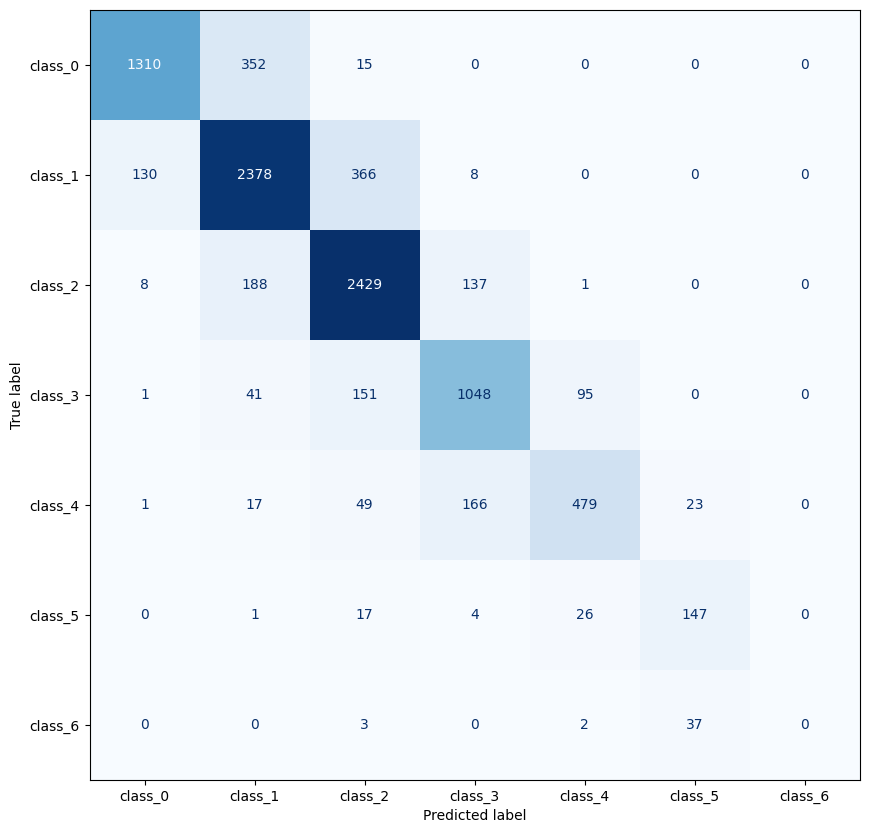

In [74]:
cm = confusion_matrix(y_true, y_pred)
dis = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=[f"class_{i}" for i in range(num_class)])
fig, ax = plt.subplots(figsize=(10, 10))
dis.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)

## 추론 수행하기

이제 모델 자체에 전처리 레이어를 포함시켰기 때문에 여러분이 개발한 모델은 이제 CSV 파일에서 행을 직접 분류할 수 있습니다.

이제 새 데이터에 대한 추론을 수행하기 전에 Model.save 및 Model.load_model로 Keras 모델을 저장하고 다시 로드할 수 있습니다.

In [75]:
def testdf_to_dataset(dataframe, batch_size=32):
    df = dataframe.copy()
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices(dict(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [76]:
test_ds = testdf_to_dataset(test_df, batch_size=batch_size)

/tmp/ipykernel_951771/937640465.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [77]:
test_ds = testdf_to_dataset(test_df, batch_size=batch_size)

/tmp/ipykernel_951771/937640465.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [78]:
pred = model.predict(test_ds)

/home/juing/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['ID'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1004/1004 [==============================] - 3s 3ms/step


In [79]:
pred

array([[3.2605228e-03, 3.9901674e-01, 5.8307827e-01, ..., 1.9682522e-03,
        3.0096871e-05, 1.9125461e-09],
       [2.3387198e-01, 3.6527932e-01, 2.6311687e-01, ..., 3.0213080e-02,
        4.6044695e-03, 8.9552719e-05],
       [9.6541423e-01, 2.9413054e-02, 5.0001843e-03, ..., 1.1258313e-06,
        3.0344989e-12, 9.4646269e-25],
       ...,
       [3.1211355e-04, 7.7643022e-03, 1.3528682e-01, ..., 1.7058307e-01,
        2.6775873e-03, 3.9517337e-05],
       [5.3295179e-10, 3.7612615e-03, 9.8876292e-01, ..., 1.6583241e-05,
        1.2340659e-07, 1.2857529e-16],
       [8.9721751e-01, 8.0478922e-02, 1.9396281e-02, ..., 1.5617188e-04,
        1.4386909e-08, 2.6008525e-16]], dtype=float32)

In [80]:
pred = np.argmax(pred, 1)

In [81]:
pred

array([2, 1, 0, ..., 3, 2, 0])

In [82]:
sample_submission["대출등급"] = [Label2Grade[i] for i in pred]

In [83]:
sample_submission

,ID,대출등급
0,TEST_00000,C
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


In [84]:
sample_submission.to_csv('baseline_submit.csv', index=False)

---